# Comparing models with different sub-sampled datasets

Analysis done in service of Sharma et al., 2025 (Shared Google Doc linked [here](https://docs.google.com/document/d/1QuqsEp6Gn-UUQTIvXMO4D3E-iXYldk0BOeQnLR4QRDw/edit?tab=t.0))

**Date Started**: January 29, 2025

**Date Last Updated**: February 4, 2025

**Changelog**:
1. January 29, 2025 - First pass
2. February 4, 2025 - Transforming all models to linear models to make R2 directly comparable

In [1]:
# Loading libraries
library(tidyverse) # General data manipulation
# library(nls2) # Non-linear model fitting | Update: this package is no longer used in the final analysis

# Setting working directory
# setwd('/Users/shashwat/Library/Mobile Documents/com~apple~CloudDocs/FunAnalyses/Sharmaetal_2025_Bagdassarian')

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
“package ‘nls2’ was built under R version 4.4.1”
Loading required package: proto

Warning message:
“package ‘proto’ was built under R version 4.4.1”


# Loading data

Current version received on January 24, 2025 (email thread linked [here](https://mail.google.com/mail/u/0/#all/FMfcgzQZSsCzGKBlpQXdPWsbHKjlsNGb))

In [2]:
df <- read_delim('power_analysis_for_shashwat.csv', delim = ',') %>%
# Removing "index" column resulting from default pandas export
select(
    -`...1`
)

df %>%
head

df %>%
dim

New names:
• `` -> `...1`
Rows: 27030 Columns: 8
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (1): model
dbl (7): ...1, fold, train_sample_size, train_corr, test_corr, train_mse, te...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


model,fold,train_sample_size,train_corr,test_corr,train_mse,test_mse
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
svr_linear,0,43,0.9722235,0.11877502,0.4183508,2.943004
svr_linear,0,43,0.9616598,0.22792376,0.4627137,2.943169
svr_linear,0,43,0.9606762,0.10688583,0.4126628,3.460259
svr_linear,0,43,0.9616273,0.34555526,0.3618266,2.898136
svr_linear,0,43,0.9527276,0.20231646,0.4129894,2.896759
svr_linear,0,43,0.9452631,0.09945692,0.4004969,3.021178


[1] 27030     7

Based on Supplementary Figure _X_ (numbered _CC_ at time of writing), the variables of interest are:
1. Pearson Correlation
2. MSE

**Assumption**: Proceeding with the `test` version of each variable here.

1. Pearson Correlation --> `test_corr`
2. MSE --> `test_mse`

## [Exploratory] Looking at training size vs Pearson Correlation

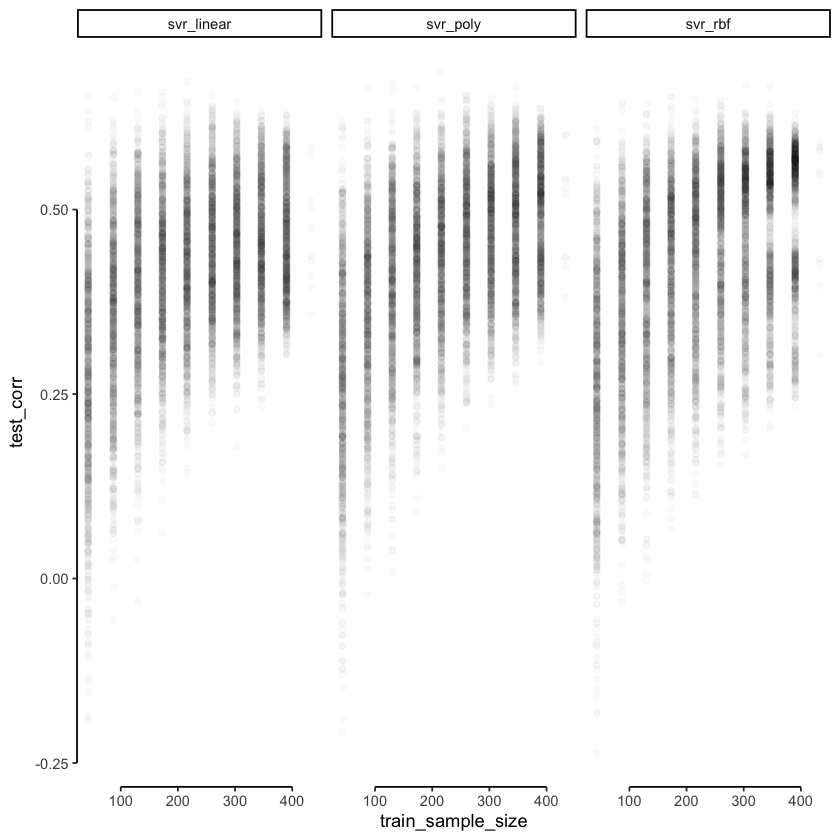

In [3]:
df %>%
ggplot(
    aes(
        train_sample_size,
        test_corr
    )
) +
geom_point(alpha = 0.02) +
theme_classic() +
guides(x = guide_axis(cap = "both"), y = guide_axis(cap = "both")) +
facet_grid(~model)

In [4]:
df %>%
count(model)

model,n
<chr>,<int>
svr_linear,9010
svr_poly,9010
svr_rbf,9010


## 1. Linear Modeling

In [5]:
linearSVR_linear_model <- lm(
    test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "svr_linear"
    )
)


summary(linearSVR_linear_model)  # Check model summar


Call:
lm(formula = test_corr ~ train_sample_size, data = df %>% filter(model == 
    "svr_linear"))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.52073 -0.06787  0.00291  0.07359  0.32571 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       3.085e-01  2.349e-03  131.35   <2e-16 ***
train_sample_size 4.589e-04  9.630e-06   47.66   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1024 on 9008 degrees of freedom
Multiple R-squared:  0.2014,	Adjusted R-squared:  0.2013 
F-statistic:  2271 on 1 and 9008 DF,  p-value: < 2.2e-16


In [6]:
polySVR_linear_model <- lm(
    test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "svr_poly"
    )
)


summary(polySVR_linear_model)  # Check model summar


Call:
lm(formula = test_corr ~ train_sample_size, data = df %>% filter(model == 
    "svr_poly"))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.53566 -0.06787  0.00813  0.07259  0.31524 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       3.047e-01  2.317e-03  131.47   <2e-16 ***
train_sample_size 5.364e-04  9.501e-06   56.45   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.101 on 9008 degrees of freedom
Multiple R-squared:  0.2613,	Adjusted R-squared:  0.2612 
F-statistic:  3187 on 1 and 9008 DF,  p-value: < 2.2e-16


In [7]:
rbfSVR_linear_model <- lm(
    test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "svr_rbf"
    )
)


summary(rbfSVR_linear_model)  # Check model summar


Call:
lm(formula = test_corr ~ train_sample_size, data = df %>% filter(model == 
    "svr_rbf"))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.56084 -0.08253  0.02656  0.08379  0.29564 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.3012577  0.0026109  115.39   <2e-16 ***
train_sample_size 0.0005437  0.0000107   50.79   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1138 on 9008 degrees of freedom
Multiple R-squared:  0.2226,	Adjusted R-squared:  0.2225 
F-statistic:  2580 on 1 and 9008 DF,  p-value: < 2.2e-16


## 2. Power Modeling

$$
    Correlation = a * {train sample size}^b
$$

To linearlize this, we can transform the data:
$$
    log_{10}(Correlation) = log_{10}(a) + log_{10}(train sample size)
$$

In [8]:
linearSVR_power_model <- lm(
    log10_test_corr ~ log10_train_sample_size,
    data = df %>%
    filter(
        model == "svr_linear"
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr),
        log10_train_sample_size = log10(train_sample_size)
    )
)


summary(linearSVR_power_model)  # Check model summary

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_corr ~ log10_train_sample_size, data = df %>% 
    filter(model == "svr_linear") %>% mutate(log10_test_corr = log10(test_corr), 
    log10_train_sample_size = log10(train_sample_size)))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.04049 -0.06341  0.01546  0.08523  0.39147 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -1.009997   0.011640  -86.77   <2e-16 ***
log10_train_sample_size  0.265751   0.005115   51.96   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1421 on 8973 degrees of freedom
  (35 observations deleted due to missingness)
Multiple R-squared:  0.2313,	Adjusted R-squared:  0.2312 
F-statistic:  2700 on 1 and 8973 DF,  p-value: < 2.2e-16


In [9]:
polySVR_power_model <- lm(
    log10_test_corr ~ log10_train_sample_size,
    data = df %>%
    filter(
        model == "svr_poly"
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr),
        log10_train_sample_size = log10(train_sample_size)
    )
)


summary(polySVR_power_model)  # Check model summary

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_corr ~ log10_train_sample_size, data = df %>% 
    filter(model == "svr_poly") %>% mutate(log10_test_corr = log10(test_corr), 
    log10_train_sample_size = log10(train_sample_size)))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.07028 -0.06094  0.02022  0.08013  0.36996 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -1.054443   0.011517  -91.56   <2e-16 ***
log10_train_sample_size  0.291118   0.005062   57.52   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1408 on 8980 degrees of freedom
  (28 observations deleted due to missingness)
Multiple R-squared:  0.2692,	Adjusted R-squared:  0.2691 
F-statistic:  3308 on 1 and 8980 DF,  p-value: < 2.2e-16


In [10]:
rbfSVR_power_model <- lm(
    log10_test_corr ~ log10_train_sample_size,
    data = df %>%
    filter(
        model == "svr_rbf"
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr),
        log10_train_sample_size = log10(train_sample_size)
    )
)


summary(rbfSVR_power_model)  # Check model summar

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_corr ~ log10_train_sample_size, data = df %>% 
    filter(model == "svr_rbf") %>% mutate(log10_test_corr = log10(test_corr), 
    log10_train_sample_size = log10(train_sample_size)))

Residuals:
     Min       1Q   Median       3Q      Max 
-1.73305 -0.07204  0.04303  0.09385  0.37490 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -1.075981   0.013065  -82.36   <2e-16 ***
log10_train_sample_size  0.297524   0.005742   51.82   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1597 on 8978 degrees of freedom
  (30 observations deleted due to missingness)
Multiple R-squared:  0.2302,	Adjusted R-squared:  0.2301 
F-statistic:  2685 on 1 and 8978 DF,  p-value: < 2.2e-16


## 3. Exponential Modeling

Correlation = a * e<sup>train_sample_size * b</sup>



$$
    Correlation = a * e^{b * {train sample size}}
$$

To linearlize this, we can transform the data:
$$
    log_{e}(Correlation) = log_{e}(a) + b * (train sample size)
$$

In [11]:
linearSVR_exp_model <- lm(
    log10_test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "svr_linear"
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr)
    )
)

summary(linearSVR_exp_model)  # Check model summary

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_corr ~ train_sample_size, data = df %>% 
    filter(model == "svr_linear") %>% mutate(log10_test_corr = log10(test_corr)))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.09734 -0.06411  0.01810  0.08979  0.33462 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -5.459e-01  3.379e-03 -161.56   <2e-16 ***
train_sample_size  6.240e-04  1.383e-05   45.13   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1463 on 8973 degrees of freedom
  (35 observations deleted due to missingness)
Multiple R-squared:  0.185,	Adjusted R-squared:  0.1849 
F-statistic:  2036 on 1 and 8973 DF,  p-value: < 2.2e-16


In [12]:
polySVR_exp_model <- lm(
    log10_test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "svr_poly"
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr)
    )
)

summary(polySVR_exp_model)  # Check model summar

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_corr ~ train_sample_size, data = df %>% 
    filter(model == "svr_poly") %>% mutate(log10_test_corr = log10(test_corr)))

Residuals:
     Min       1Q   Median       3Q      Max 
-2.13030 -0.06135  0.02113  0.08636  0.31211 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -5.488e-01  3.349e-03 -163.89   <2e-16 ***
train_sample_size  6.963e-04  1.371e-05   50.79   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1452 on 8980 degrees of freedom
  (28 observations deleted due to missingness)
Multiple R-squared:  0.2232,	Adjusted R-squared:  0.2231 
F-statistic:  2580 on 1 and 8980 DF,  p-value: < 2.2e-16


In [13]:
rbfSVR_exp_model <- lm(
    log10_test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "svr_rbf"
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr)
    )
)

summary(rbfSVR_exp_model)  # Check model summar

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”



Call:
lm(formula = log10_test_corr ~ train_sample_size, data = df %>% 
    filter(model == "svr_rbf") %>% mutate(log10_test_corr = log10(test_corr)))

Residuals:
     Min       1Q   Median       3Q      Max 
-1.71591 -0.07455  0.03812  0.10281  0.31356 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)       -5.592e-01  3.779e-03    -148   <2e-16 ***
train_sample_size  7.116e-04  1.547e-05      46   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1638 on 8978 degrees of freedom
  (30 observations deleted due to missingness)
Multiple R-squared:  0.1908,	Adjusted R-squared:  0.1907 
F-statistic:  2116 on 1 and 8978 DF,  p-value: < 2.2e-16


## Calculating Performance Metrics

In [14]:
# Function to calculate performance metrics
calc_metrics <- function(model, data, ground_truth, log_transformed = FALSE) {
    
  predicted_vals <- predict(model, newdata = data)
    
  # If the model was fit in log-space, exponentiate predictions
  if (log_transformed) {
    predicted_vals <- exp(predicted_vals)
  }
  
  mse <- mean((predicted_vals - ground_truth)^2)
  rmse <- sqrt(mse)
  
  return(c(MSE = mse, RMSE = rmse))
}


In [15]:
input_models <- c("linear", "poly", "rbf") # the variable names here are a little confusing
model_types <- c("linear", "power", "exp") # the variable names here are a little confusing

flag <- 0 # Setting Sentinel

for (curr_input in input_models) {
    curr_df <- df %>%
    filter(
        model == paste0("svr_", curr_input)
    ) %>%
    mutate(
        log10_test_corr = log10(test_corr),
        log10_train_sample_size = log10(train_sample_size)
    )

    curr_linear_model <- linearSVR_linear_model <- lm(
        test_corr ~ train_sample_size,
        data = curr_df
    )

    curr_power_model <- lm(
        log10_test_corr ~ log10_train_sample_size,
        data = curr_df
    )
    
    curr_exp_model <- lm(
        log10_test_corr ~ train_sample_size,
        data = curr_df
    )
    
    for (curr_model in model_types) {
        curr_stat_model <- get(paste0("curr_", curr_model, "_model"))
        
        # Below, I'm calculating a lot of different linear model performance
        # metrics - but only 1 will be used for the final comparison.
        
        if (curr_model %in% c("power", "exp")) {
            curr_metrics <- calc_metrics(curr_stat_model, curr_df, curr_df$test_corr, log_transformed = T) %>%
            t() %>%
            data.frame
        } else {
            curr_metrics <- calc_metrics(curr_stat_model, curr_df, curr_df$test_corr) %>%
            t() %>%
            data.frame
        }
        
        curr_metrics$R2 <- summary(curr_stat_model)$r.squared
        
        curr_metrics$R2_adj <- summary(curr_stat_model)$adj.r.squared

        curr_metrics$AIC <- AIC(curr_stat_model)
        curr_metrics$BIC <- BIC(curr_stat_model)

        curr_metrics$Input <- paste0(curr_input, "SVR")
        curr_metrics$Model <- curr_model

        if (flag == 0) {
            final_df <- curr_metrics
            flag <- 1 # Changing Sentinel
        } else {
            final_df <- rbind(final_df, curr_metrics)
        }
    }
}

final_df %>%
write_delim('Output/PerformanceMetricDF_4Feb2025.txt', delim = '\t')

final_df %>%
arrange(
    RMSE,
    desc(R2_adj)
)

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `log10_test_corr = log10(test_corr)`.
Caused by warning:
! NaNs produced”


MSE,RMSE,R2,R2_adj,AIC,BIC,Input,Model
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.01019534,0.1009720,0.2613156,0.2612336,-15743.011,-15721.692,polySVR,linear
0.01047400,0.1023426,0.2013617,0.2012730,-15500.050,-15478.731,linearSVR,linear
0.01294108,0.1137588,0.2226289,0.2225426,-13594.341,-13573.023,rbfSVR,linear
0.07384660,0.2717473,0.2692041,0.2691227,-9723.729,-9702.420,polySVR,power
0.07425839,0.2725039,0.2231523,0.2230658,-9174.838,-9153.529,polySVR,exp
0.07517000,0.2741715,0.2302063,0.2301206,-7454.530,-7433.222,rbfSVR,power
0.07557188,0.2749034,0.1907590,0.1906688,-7005.761,-6984.453,rbfSVR,exp
0.07611202,0.2758841,0.2312788,0.2311932,-9552.691,-9531.384,linearSVR,power
0.07652977,0.2766401,0.1849728,0.1848820,-9027.715,-9006.408,linearSVR,exp


> RMSE should be used for comparison here since the models we are building are **predictive** (confirm with Hratch B.).

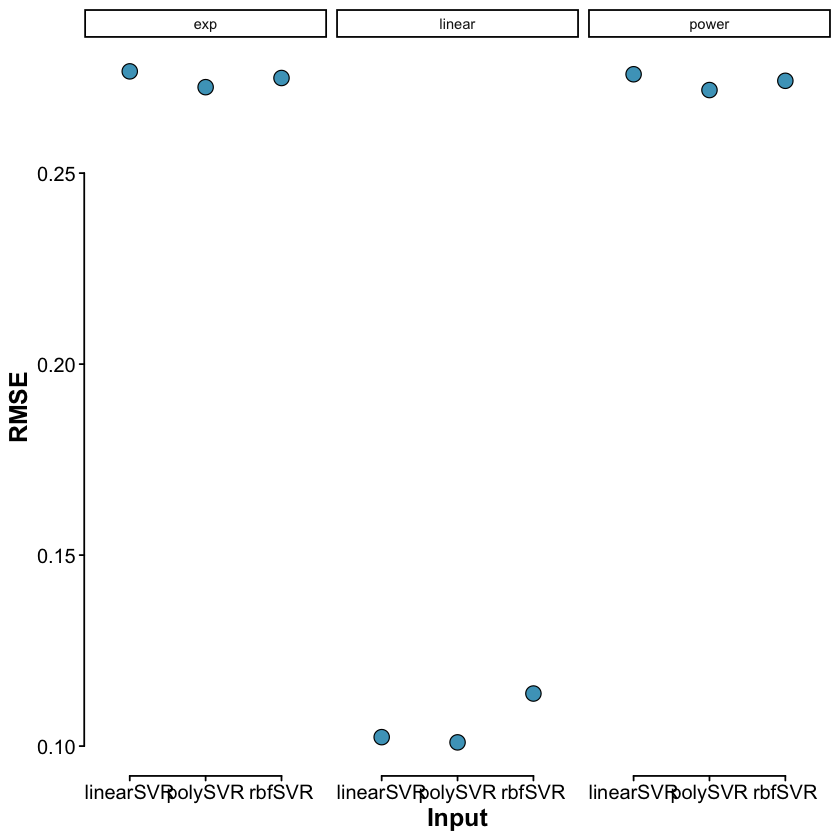

In [16]:
final_df %>%
ggplot(
    aes(
        Input,
        RMSE
    )
) +
geom_point(pch = 21, size = 4, fill = '#4BA3C3', color = 'black') +
theme_classic() +
guides(x = guide_axis(cap = "both"), y = guide_axis(cap = "both")) +
facet_grid(~Model) +
# Adding my personal theme
theme(
    panel.background = element_rect(fill = 'transparent', color = NA_character_),
    plot.background = element_rect(fill = 'transparent', color = NA_character_),
    axis.ticks = element_line(color = 'black', lineend = 'round'),
    axis.line = element_line(color = 'black', lineend = 'round'),
    axis.text = element_text(size = 12, color = 'black'),
    axis.title = element_text(size = 15, color = 'black', face = 'bold')
)

ggsave('Output/RMSEComparison_4Feb2025.pdf', units = 'in', h = 6, w = 8, useDingbats = F, )

In [ ]:
0.01019534	0.1009720	0.2613156	0.2612336	-15743.011	-15721.692	polySVR	linear
0.01047400	0.1023426	0.2013617	0.2012730	-15500.050	-15478.731	linearSVR	linear
0.01294108	0.1137588	0.2226289	0.2225426	-13594.341	-13573.023	rbfSVR	linear
0.07384660	0.2717473	0.2692041	0.2691227	-9723.729	-9702.420	polySVR	power
0.07425839	0.2725039	0.2231523	0.2230658	-9174.838	-9153.529	polySVR	exp
0.07517000	0.2741715	0.2302063	0.2301206	-7454.530	-7433.222	rbfSVR	power
0.07557188	0.2749034	0.1907590	0.1906688	-7005.761	-6984.453	rbfSVR	exp
0.07611202	0.2758841	0.2312788	0.2311932	-9552.691	-9531.384	linearSVR	power
0.07652977	0.2766401	0.1849728	0.1848820	-9027.715	-9006.408	linearSVR	exp

## Cell Graveyard

Below are cells that were previously tried/used to pilot analyses

## 1. Linear Modeling

In [17]:
linearSVR_linear_model <- lm(
    test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "svr_linear"
    )
)


summary(linearSVR_linear_model)  # Check model summar


Call:
lm(formula = test_corr ~ train_sample_size, data = df %>% filter(model == 
    "svr_linear"))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.52073 -0.06787  0.00291  0.07359  0.32571 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       3.085e-01  2.349e-03  131.35   <2e-16 ***
train_sample_size 4.589e-04  9.630e-06   47.66   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1024 on 9008 degrees of freedom
Multiple R-squared:  0.2014,	Adjusted R-squared:  0.2013 
F-statistic:  2271 on 1 and 9008 DF,  p-value: < 2.2e-16


In [18]:
polySVR_linear_model <- lm(
    test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "svr_poly"
    )
)


summary(polySVR_linear_model)  # Check model summar


Call:
lm(formula = test_corr ~ train_sample_size, data = df %>% filter(model == 
    "svr_poly"))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.53566 -0.06787  0.00813  0.07259  0.31524 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       3.047e-01  2.317e-03  131.47   <2e-16 ***
train_sample_size 5.364e-04  9.501e-06   56.45   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.101 on 9008 degrees of freedom
Multiple R-squared:  0.2613,	Adjusted R-squared:  0.2612 
F-statistic:  3187 on 1 and 9008 DF,  p-value: < 2.2e-16


In [19]:
rbfSVR_linear_model <- lm(
    test_corr ~ train_sample_size,
    data = df %>%
    filter(
        model == "svr_rbf"
    )
)


summary(rbfSVR_linear_model)  # Check model summar


Call:
lm(formula = test_corr ~ train_sample_size, data = df %>% filter(model == 
    "svr_rbf"))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.56084 -0.08253  0.02656  0.08379  0.29564 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.3012577  0.0026109  115.39   <2e-16 ***
train_sample_size 0.0005437  0.0000107   50.79   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1138 on 9008 degrees of freedom
Multiple R-squared:  0.2226,	Adjusted R-squared:  0.2225 
F-statistic:  2580 on 1 and 9008 DF,  p-value: < 2.2e-16


## 2. Power Modeling

$$
    Correlation = a * {train sample size}^b
$$

In [20]:
linearSVR_power_model <- nls(
    test_corr ~ a * train_sample_size^b,
    start = list(a = 1, b = -0.5),
    data = df %>%
    filter(
        model == "svr_linear"
    )
)


summary(linearSVR_power_model)  # Check model summar


Formula: test_corr ~ a * train_sample_size^b

Parameters:
  Estimate Std. Error t value Pr(>|t|)    
a 0.136096   0.003178   42.83   <2e-16 ***
b 0.209669   0.004329   48.44   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1002 on 9008 degrees of freedom

Number of iterations to convergence: 9 
Achieved convergence tolerance: 1.263e-06


In [21]:
polySVR_power_model <- nls(
    test_corr ~ a * train_sample_size^b,
    start = list(a = 1, b = -0.5),
    data = df %>%
    filter(
        model == "svr_poly"
    )
)


summary(polySVR_power_model)  # Check model summar


Formula: test_corr ~ a * train_sample_size^b

Parameters:
  Estimate Std. Error t value Pr(>|t|)    
a 0.122636   0.002792   43.93   <2e-16 ***
b 0.235256   0.004208   55.91   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.09879 on 9008 degrees of freedom

Number of iterations to convergence: 8 
Achieved convergence tolerance: 2.562e-06


In [22]:
rbfSVR_power_model <- nls(
    test_corr ~ a * train_sample_size^b,
    start = list(a = 1, b = -0.5),
    data = df %>%
    filter(
        model == "svr_rbf"
    )
)


summary(rbfSVR_power_model)  # Check model summar


Formula: test_corr ~ a * train_sample_size^b

Parameters:
  Estimate Std. Error t value Pr(>|t|)    
a 0.119471   0.003103   38.51   <2e-16 ***
b 0.239376   0.004798   49.89   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1119 on 9008 degrees of freedom

Number of iterations to convergence: 8 
Achieved convergence tolerance: 2.279e-06


## 3. Exponential Modeling

$$
    Correlation = a * e^{b * {train sample size}}
$$

In [23]:
linearSVR_exp_model <- nls(
    test_corr ~ a * exp(b * train_sample_size),
    start = list(a = 0.05, b = 0.005),
    data = df %>%
    filter(
        model == "svr_linear"
    )
)

summary(linearSVR_exp_model)  # Check model summar


Formula: test_corr ~ a * exp(b * train_sample_size)

Parameters:
   Estimate Std. Error t value Pr(>|t|)    
a 3.212e-01  2.056e-03  156.23   <2e-16 ***
b 1.072e-03  2.397e-05   44.71   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.103 on 9008 degrees of freedom

Number of iterations to convergence: 6 
Achieved convergence tolerance: 2.469e-06


In [24]:
polySVR_exp_model <- nls(
    test_corr ~ a * exp(b * train_sample_size),
    start = list(a = 0.05, b = 0.005),
    data = df %>%
    filter(
        model == "svr_poly"
    )
)


summary(polySVR_exp_model)  # Check model summar


Formula: test_corr ~ a * exp(b * train_sample_size)

Parameters:
   Estimate Std. Error t value Pr(>|t|)    
a 3.204e-01  1.993e-03  160.79   <2e-16 ***
b 1.218e-03  2.303e-05   52.88   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1018 on 9008 degrees of freedom

Number of iterations to convergence: 6 
Achieved convergence tolerance: 1.71e-06


In [25]:
rbfSVR_exp_model <- nls(
    test_corr ~ a * exp(b * train_sample_size),
    start = list(a = 0.05, b = 0.005),
    data = df %>%
    filter(
        model == "svr_rbf"
    )
)


summary(rbfSVR_exp_model)  # Check model summar


Formula: test_corr ~ a * exp(b * train_sample_size)

Parameters:
   Estimate Std. Error t value Pr(>|t|)    
a 3.174e-01  2.235e-03  142.01   <2e-16 ***
b 1.240e-03  2.604e-05   47.63   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1145 on 9008 degrees of freedom

Number of iterations to convergence: 6 
Achieved convergence tolerance: 1.75e-06
